In [1]:
from netCDF4 import Dataset
from cartoplot import cartoplot
import numpy as np
import datetime
from pyproj import Proj, transform
from scipy.spatial.kdtree import KDTree
import pandas as pd
import matplotlib.pyplot as plt
from ll_xy import lonlat_to_xy
import cartopy.crs as ccrs
import cartopy
import pickle
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
import cartopy
import numpy.ma as ma
import matplotlib.pyplot as plt
import pandas as pd


/tmp/ipykernel_14194/680372591.py:6: DeprecationWarning: Please import `KDTree` from the `scipy.spatial` namespace; the `scipy.spatial.kdtree` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.kdtree import KDTree


In [2]:
pmw_f = 'ice_conc_sh_polstere-100_multi_202204221200.nc'
pmw_d = Dataset(f'../data/OSISAF_pmw/{pmw_f}')
pmw_lon = np.array(pmw_d['lon'])
pmw_lat = np.array(pmw_d['lat'])

In [3]:
floes_df = pd.read_csv('../data/floe_coords.csv',parse_dates=['dt'])

dates = [dt.date() for dt in floes_df['dt']]

In [4]:
ddir = '../data/OSISAF_imv/'

def get_date_str(date):

    day = date.day
    month = date.month
    year = date.year
    
    date_str = f'{year}{str(month).zfill(2)}{str(day).zfill(2)}'
    
    return date_str

def get_imv_on_date(date):

    d1 = get_date_str(date-datetime.timedelta(days=1))
    d2 = get_date_str(date+datetime.timedelta(days=1))
    
    floc = f'{ddir}ice_drift_sh_polstere-625_multi-oi_{d1}1200-{d2}1200.nc'
    
    d = Dataset(floc)

    return d



In [5]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3409')
pmw_x,pmw_y = transform(inProj,outProj,pmw_lon,pmw_lat)
pmw_tree = KDTree(list(zip(pmw_x.ravel(),pmw_y.ravel())))

def check_landice(x,y):
    
    dist, ind = pmw_tree.query((x,y))

    unraveled = np.unravel_index(ind, pmw_x.shape)

    land_ice_data = np.array(pmw_d['ice_conc'][0])[unraveled]
    
    if land_ice_data == -999:
        
        return True
    
    else:
        
        return False

/home/robbie/anaconda3/envs/dye_brine/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/robbie/anaconda3/envs/dye_brine/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_14194/701757649.py:3: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

In [6]:

d = get_imv_on_date(dates[-1])
imv_lons = np.array(d['lon'])
imv_lats = np.array(d['lat'])

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3409')
x,y = transform(inProj,outProj,imv_lons,imv_lats)
tree = KDTree(list(zip(x.ravel(),y.ravel())))

dx_last_day = np.array(d['dX'][0])

dx_last_day[dx_last_day<-10_000] = np.nan

/home/robbie/anaconda3/envs/dye_brine/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/robbie/anaconda3/envs/dye_brine/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_14194/3578872058.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-

In [7]:
dfs = []

for date, lon, lat in zip(dates,floes_df['lon'],floes_df['lat']):
    
    print(date)

    # Find position
    
    current_date = date

    x,y = transform(inProj,outProj,lon,lat)

    list_of_dicts = []
    
    dx= 1
    
    while dx < 10_00000:
        

        # Get nearest vectors
    
        dist, ind = tree.query((x,y))
        
        unraveled = np.unravel_index(ind, imv_lons.shape)

        d = get_imv_on_date(current_date)

        dx = -int(np.array(d['dX'])[0][unraveled]*1000/2)
        dy = -int(np.array(d['dY'])[0][unraveled]*1000/2)
        
        if dx > 10_00000:
            
            dxdata = np.array(d['dX'][0])
            dydata = np.array(d['dY'][0])
            dxdata[dxdata<-10_000] = np.nan
            
            
            imv_lons_c = imv_lons[~np.isnan(dxdata)]
            imv_lats_c = imv_lats[~np.isnan(dxdata)]
            dydata_c = dydata[~np.isnan(dxdata)]
            dxdata_c = dxdata[~np.isnan(dxdata)]
            
            x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)
            tree_c = KDTree(list(zip(x_c.ravel(),y_c.ravel())))
            
            dist, ind = tree_c.query((x,y))
        
            dx = -int(dxdata_c[ind]*1000/2)
            dy = -int(dydata_c[ind]*1000/2)
            
        x = x + dx
        y = y + dy
        current_date = current_date - datetime.timedelta(days=1)

        list_of_dicts.append({'date':current_date,
                               'dx':dx,
                               'dy':dy,
                               'distance':dist,
                               'x':x,
                               'y':y})
        
        if dist > 200_000:
            print('Reaching Too Far')
            break
            
        if current_date == datetime.date(2021,1,1):
            print('Preceeding 2021-1-1')
            break
            
        if check_landice(x,y) == True:
            print('Hit Land Ice')
            break

        
    df = pd.DataFrame(list_of_dicts)
    
    df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
    
    dfs.append(df)
    

2022-04-11


/tmp/ipykernel_14194/1664635838.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_14194/1664635838.py:43: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)


Hit Land Ice
2022-04-16


/tmp/ipykernel_14194/1664635838.py:77: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
/tmp/ipykernel_14194/1664635838.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_14194/1664635838.py:43: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)


Hit Land Ice
2022-04-17


/tmp/ipykernel_14194/1664635838.py:77: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
/tmp/ipykernel_14194/1664635838.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_14194/1664635838.py:43: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)


Reaching Too Far
2022-04-19


/tmp/ipykernel_14194/1664635838.py:77: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
/tmp/ipykernel_14194/1664635838.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_14194/1664635838.py:43: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)


Preceeding 2021-1-1
2022-04-22


/tmp/ipykernel_14194/1664635838.py:77: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])
/tmp/ipykernel_14194/1664635838.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x,y = transform(inProj,outProj,lon,lat)
/tmp/ipykernel_14194/1664635838.py:43: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_c,y_c = transform(inProj,outProj,imv_lons_c,imv_lats_c)


Preceeding 2021-1-1


/tmp/ipykernel_14194/1664635838.py:77: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  df['lon'],df['lat'] = transform(outProj,inProj,df['x'],df['y'])


In [9]:
pmw_data = pmw_d['ice_conc'][0].copy()
pmw_data[pmw_data>0.5] = 2
pmw_data[pmw_data<0] = 1
pmw_data[pmw_data<0.5] = np.nan





# Save out the data from this notebook to make the manuscript plot using Make_Figure_1.ipynb

In [12]:
pickle.dump((pmw_lon,pmw_lat,pmw_data,floes_df,dfs,dates),open('../data/f1map.p','wb'))

# Make a Plot of the Trajectories

/home/robbie/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/robbie/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


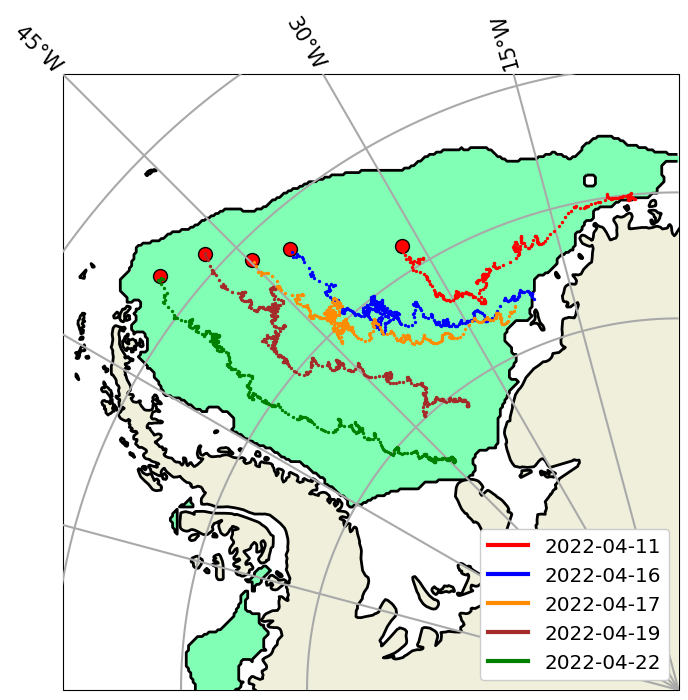

In [13]:
# Make plot

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=9,linewidth=2)

ax.set_extent([-80, -10, -90, -65], ccrs.PlateCarree())

scat = ax.scatter(floes_df['lon'],
                  floes_df['lat'],
                  transform=ccrs.PlateCarree(),
                  marker='o',
                  color='r',
                  edgecolor='k',
                  s=100,
                  zorder=9,)



colors = ['r','b','darkorange','brown','green']    

for df_traj, date, color in zip(dfs,dates,colors):

    scat = ax.scatter(df_traj['lon'],
                      df_traj['lat'],
                      c=color,
#                       c='r',
                      transform=ccrs.PlateCarree(),
                      marker='o',
                      s=2,
                      zorder=15)
    
    ax.plot([],[],color=color,label=date,lw=3)

###################################

lon2d_greater = ma.masked_greater(np.array(pmw_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(pmw_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(pmw_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(np.array(pmw_d['ice_conc'][0]), mask=lon2d_greater.mask)


cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0],
                  transform=ccrs.PlateCarree(),
                  zorder=6,
                    linewidths=[2],
                  colors=['k'])


##################################


mesh = ax.pcolormesh(pmw_lon,pmw_lat,
                     pmw_data,
                         cmap='rainbow',
                     transform=ccrs.PlateCarree(),
                    vmin=0,vmax=4,zorder=5)

gl = ax.gridlines(zorder=10,color='darkgrey',linewidth=1.5)
gl.xlabel_style = {'size': 15, 'color': 'k'}

gl.ylocator = mticker.FixedLocator(np.arange(-60,-80,-5))
gl.xlocator = mticker.FixedLocator(np.arange(0,-91,-15))

gl.ylabels_left = True
gl.xlabels_top = True


plt.legend(loc='lower right',fontsize='x-large',facecolor='white',framealpha=1).set_zorder(102) 

overleaf_dir = '/home/robbie/Dropbox/Apps/Overleaf/KuKa_Weddell/main_figs'

# plt.savefig('../figures/floe_trajectories.jpg',dpi=400,bbox_inches='tight')

# plt.savefig(f'{overleaf_dir}/Fig1.jpg',dpi=400,bbox_inches='tight')

# plt.show()

In [11]:
for df, date in zip(dfs, dates):
    
    df.to_csv(f'../data/{date}-trajectory.csv')